# Screening Task 1 for QOSF Mentorship

## Please explain the problem

1. Problem statement (Add images)

2. An overview of my approach. 3 different methods. Statevector_simulator, qasm_simulator, pennylane

3. Show the approaches and add proper documentation to the functions defined.

4. Explain differences of the approaches taken.

5. Conclusions, further work and things to try.


$\varepsilon = min_{\theta}\left \| \Psi(\theta) - \phi \rangle \right \| = 0$

$\mathrm{Re}\left \{ \langle \Psi(\theta) - \phi| \Psi(\theta) - \phi \rangle \right \} = 1$

document <a href="https://docs.google.com/document/d/1Ow3v8Y4rYBdgxXNxKV9ZUAM4bwL6211U6DWCcByZ4A4/edit" target="_blank">this link</a>.

![Markdown Logo is here.](https://www.fullstackpython.com/img/logos/markdown.png)

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

## Generating a proper random quantum state and its probability vector

Explain some things here
$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

$|v| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$

In [10]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int) -> np.array:
    """Creates a normalized random complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
    Returns:
        (np.array): normalized complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of the respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))

In [11]:
#two qubits -> a complex vector of dimension 4
n_qubits = 3
dim = 2**(n_qubits)
psi = random_quantum_state(dim)

In [12]:
get_probabilities(psi)

tensor([0.08423785, 0.25958127, 0.00628017, 0.1203082 , 0.24069285,
        0.15627627, 0.10734114, 0.02528227], requires_grad=True)

## Building the variational quantum circuit in Qiskit

In [13]:
def build_variational_circuit(number_layers: int, params: np.array) -> QuantumCircuit:
    #how many parameters will have given the number_layers
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
            
        return qc
    
def layer(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(qc, params[:int(n_parameters/2)])
        even_block(qc, params[int(n_parameters/2):])
        qc.barrier()
        
#qiskit  odd block
def odd_block(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rx(params[i], i)
        
#qiskit even block
def even_block(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rz(params[i], i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qc.cz(tup[0], tup[1])

In [14]:
n_parameters_per_layer = 8
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)

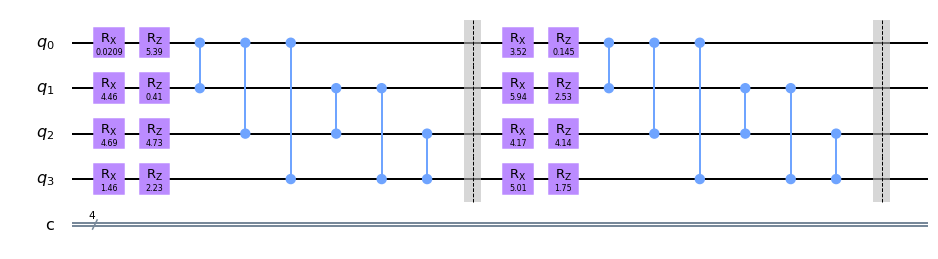

In [15]:
qc.draw(output='mpl')

## Optimization

In [16]:
backend = Aer.get_backend('statevector_simulator')

job = execute(qc, backend)

result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[ 0.02178875+0.07201153j -0.40244632+0.04960706j -0.05479845-0.06714865j
 -0.41810054+0.22309916j -0.00610353-0.0162542j  -0.07362156+0.02015074j
  0.05051629+0.0347007j  -0.21349133+0.23679156j  0.00091329-0.00057699j
 -0.00856107+0.00717497j -0.05033388+0.03331912j -0.13363137-0.28704683j
  0.05111545-0.07286295j  0.3328485 +0.2968668j   0.03892776-0.07365886j
 -0.34090546-0.22862618j]


In [17]:
def norm_vector_difference(params):
    
    qc = build_variational_circuit(n_layers, params)
    
    job = execute(qc, backend)
    
    result = job.result()

    outputstate = result.get_statevector(qc, decimals=3)
    
    diff = outputstate - target_vector
    
    
    return norm(diff)

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    output_distr = np.asarray(output_distr)
    
    return output_distr

def probability_difference(params):
    # Obtain a quantum circuit instance from the paramters
    qc = build_variational_circuit(n_layers, params)
    # Measure all qubits
    qc.measure_all()
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.absolute(output_distr[i] - target_distr[i]) for i in range(output_distr.shape[0])])
    return cost

In [18]:
n_qubits = 4
dim = n_qubits**2
target_vector = random_quantum_state(dim)
target_distr = get_probabilities(target_vector)

In [19]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
cost_list = []
for n_layers in range(1,11):
    n_parameters_per_layer = 8
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=norm_vector_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    final_vector = execute(qc, backend).result().get_statevector(qc, decimals = 3)
    
    #save cost function values
    cost_list.append(ret[1])
    
    print("Number of layers:", n_layers)
    print("Target Vector:", target_vector)
    print("Obtained Vector:", final_vector)
    print("Norm difference:", ret[1])
    print("Parameters Found:", ret[0])
    print('')

Number of layers: 1
Target Vector: [0.32412364+0.09287884j 0.25061448+0.09955364j 0.31111025+0.01993548j
 0.30346345+0.04086106j 0.28765401+0.0437183j  0.11642566+0.20815363j
 0.24434722+0.00573693j 0.20354419+0.28414697j 0.00660398+0.05214332j
 0.01258437+0.01819374j 0.04182362+0.05816268j 0.09560594+0.15850192j
 0.1636316 +0.20420812j 0.20974489+0.15566534j 0.01243335+0.03421132j
 0.2363927 +0.25030015j]
Obtained Vector: [ 0.1413825 +0.j         -0.00910581+0.20334254j  0.12048842+0.25300109j
  0.37163742-0.15699709j -0.0125737 +0.17401395j  0.2494647 +0.0292915j
  0.32210989-0.12579708j  0.16018125+0.47137465j -0.04117077+0.06701386j
  0.09373066+0.06352967j  0.15500631+0.01656396j -0.03380628+0.22187009j
  0.07881935+0.05663289j -0.08652832+0.109714j   -0.03417229+0.18930907j
  0.27007176+0.06134063j]
Norm difference: 0.8367571674989513
Parameters Found: [1.92741257 2.20706417 4.50365136 5.26785804 3.18634341 2.69713571
 0.07213148 6.8340982 ]

Number of layers: 2
Target Vector: [0

Number of layers: 8
Target Vector: [0.32412364+0.09287884j 0.25061448+0.09955364j 0.31111025+0.01993548j
 0.30346345+0.04086106j 0.28765401+0.0437183j  0.11642566+0.20815363j
 0.24434722+0.00573693j 0.20354419+0.28414697j 0.00660398+0.05214332j
 0.01258437+0.01819374j 0.04182362+0.05816268j 0.09560594+0.15850192j
 0.1636316 +0.20420812j 0.20974489+0.15566534j 0.01243335+0.03421132j
 0.2363927 +0.25030015j]
Obtained Vector: [ 0.38356302+0.07100864j  0.27398499+0.12027918j  0.36319318+0.09027873j
  0.21478545-0.02717554j  0.26673931+0.09561239j  0.06251557+0.19593001j
  0.2573602 -0.00470886j  0.15637885+0.17805132j -0.09121664-0.02206346j
  0.01468582+0.03695669j  0.07802202+0.14036573j  0.07923146+0.21766543j
  0.12051336+0.15602711j  0.22601048+0.17337475j  0.01272946+0.03908861j
  0.22975733+0.24909765j]
Norm difference: 0.2778170553896721
Parameters Found: [6.96800343 3.77856169 5.20113181 3.44806168 4.04912092 5.24572862
 5.40436957 5.11471314 4.68902978 5.41626156 5.23439609 4.050

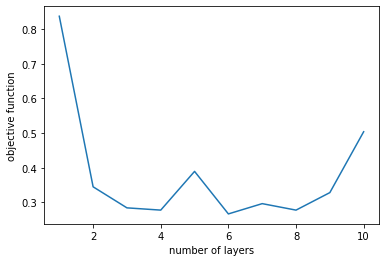

In [20]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

In [21]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
n_parameters_per_layer = 8
cost_list = []
for n_layers in range(1,11):
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=probability_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    qc.measure_all()
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    output_distr = get_probability_distribution(counts)
    
    cost_list.append(ret[1])
    
    print("Number of layers:", n_layers)
    print("Target Distribution:", target_distr)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", ret[1])
    print("Parameters Found:", ret[0])
    print('')

Number of layers: 1
Target Distribution: [0.11368261 0.07271854 0.09718701 0.09375969 0.08465612 0.05688287
 0.05973848 0.12216974 0.00276254 0.00048938 0.00513211 0.03426336
 0.06847626 0.06822462 0.001325   0.11853167]
Obtained Distribution: [0.053  0.0919 0.0536 0.0918 0.0812 0.1208 0.0778 0.1264 0.0216 0.0373
 0.0265 0.039  0.0342 0.0545 0.0358 0.0546]
Output Error (Manhattan Distance): 0.45003597031329784
Parameters Found: [4.47061745 4.71494281 4.52549243 1.16552576 0.44412187 2.97348371
 2.73789441 1.86984822]

Number of layers: 2
Target Distribution: [0.11368261 0.07271854 0.09718701 0.09375969 0.08465612 0.05688287
 0.05973848 0.12216974 0.00276254 0.00048938 0.00513211 0.03426336
 0.06847626 0.06822462 0.001325   0.11853167]
Obtained Distribution: [0.1181 0.0523 0.0971 0.0504 0.0773 0.0853 0.0618 0.1303 0.007  0.0035
 0.0071 0.0026 0.0523 0.071  0.0736 0.1103]
Output Error (Manhattan Distance): 0.23844953254592957
Parameters Found: [1.52205585 6.11164691 5.30435426 2.1911518 

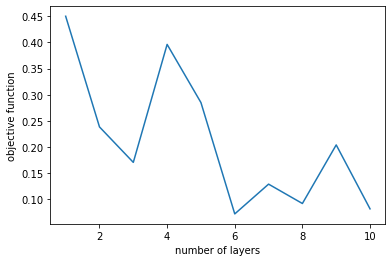

In [22]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

## Optimize the variational circuit using Pennylane

In [23]:
dev = qml.device('default.qubit', wires = 4)

In [24]:
target_vector = target_vector.reshape((16,1))
density_matrix = target_vector @ np.transpose(np.conjugate(target_vector))
print(density_matrix.shape)

(16, 16)


In [25]:
def layer(params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(params[:int(n_parameters/2)])
        even_block(params[int(n_parameters/2):])

def odd_block(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RX(params[i], wires = i)
        

def even_block(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RZ(params[i], wires = i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qml.CZ(wires=[tup[0], tup[1]])

In [26]:
@qml.qnode(dev)
def var_circuit(params):

    #number of parameters per layer
    n_parameters_per_layer = 8
    for i in range(number_layers):
        start = i*n_parameters_per_layer
        end = (i+1)*n_parameters_per_layer 
        layer(params[start:end])

    return qml.expval(qml.Hermitian(density_matrix, wires=[0,1,2,3]))

In [27]:
def cost(x):
    
    return (1.0 - var_circuit(x))

In [28]:
n_parameters_per_layer = 8
number_layers = 1
params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

cost(params)

0.9865831714613834

In [29]:
init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

In [30]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [31]:
cost_list = []
for number_layers in range(1,11):
    init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi
    opt = qml.GradientDescentOptimizer(stepsize = 0.4)

    steps = 100

    params = init_params
    for i in range(steps):

        params = opt.step(cost, params)

    print(cost(params))
    cost_list.append(cost(params))

0.7227465105229097
0.1309960630235848
0.07542990193198362
0.027576642518004735
0.002942209207676183
0.0015538668439672998
4.739579864210253e-05
0.00015171673160196963
7.908822598934329e-06
2.0571253922518906e-08


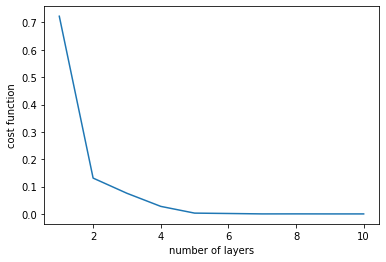

In [32]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("cost function")
plt.show()

## Conclusions